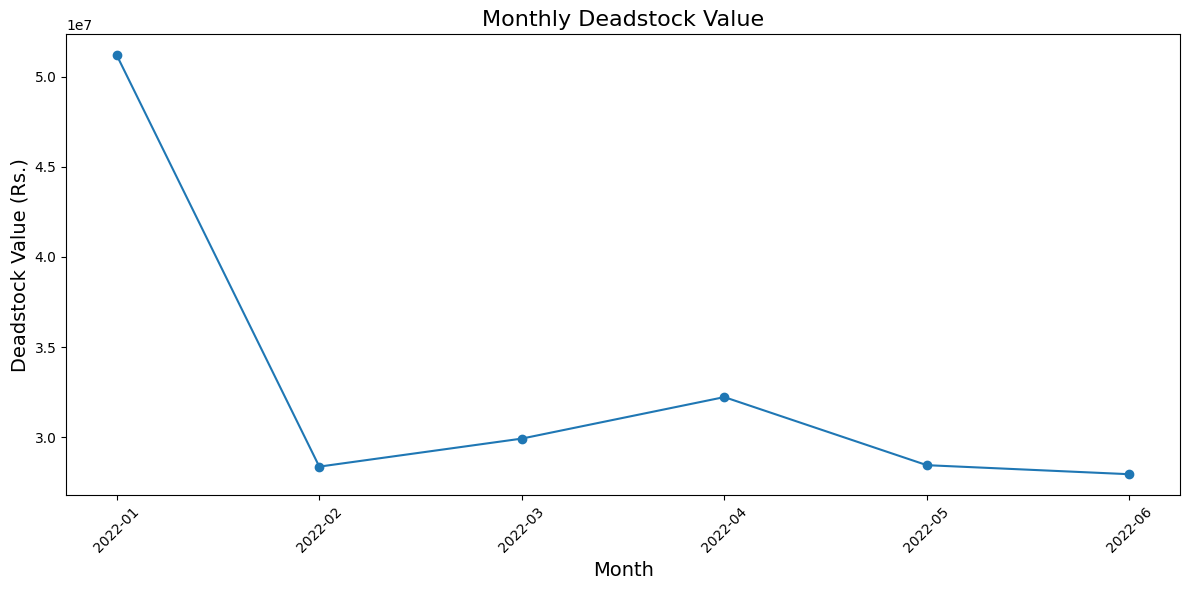

ADF Statistic: -10.7512
p-value: 0.0000


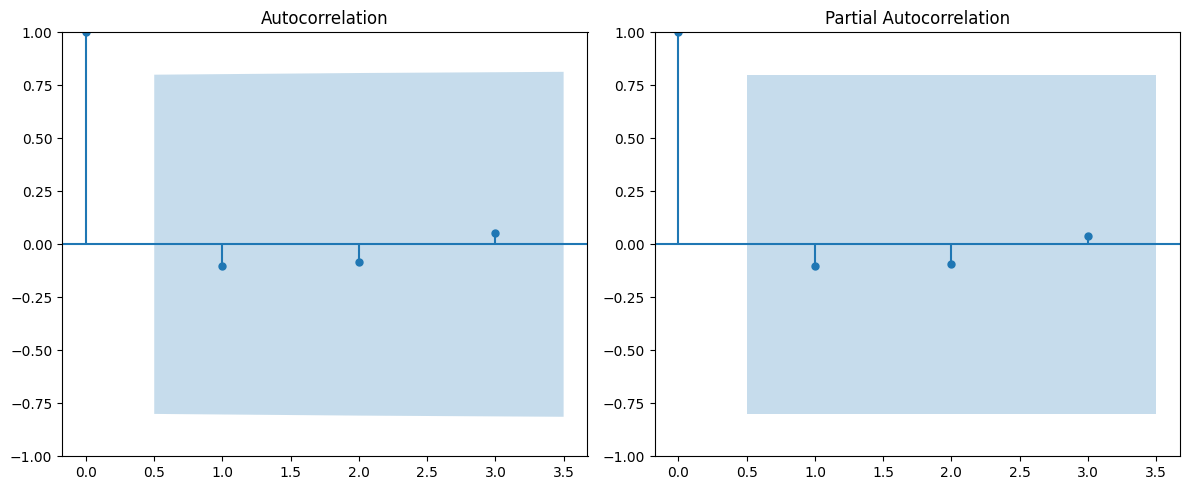

C:\Users\arvin\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\arvin\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\arvin\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\arvin\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


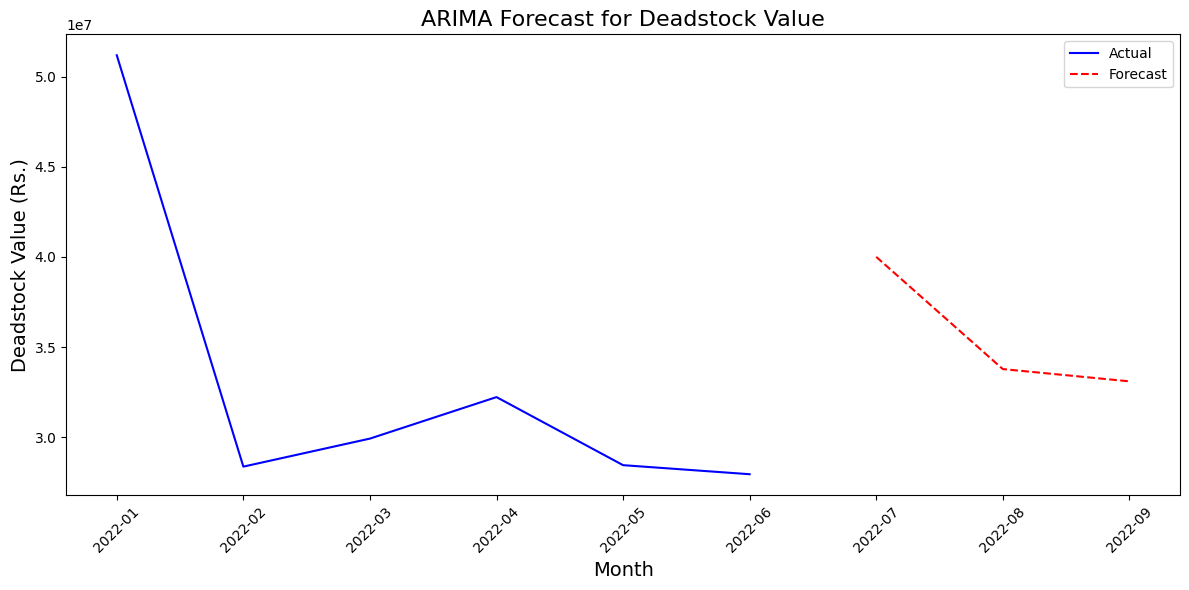

Forecasted deadstock for 2022-07: Rs.40,001,654.26
Forecasted deadstock for 2022-08: Rs.33,778,181.94
Forecasted deadstock for 2022-09: Rs.33,098,998.98


In [2]:
# Time Series Analysis with ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load and prepare data
deadstock_df = pd.read_excel("deadstock_cleaned.xlsx")
deadstock_df['Received Date'] = pd.to_datetime(deadstock_df['Received Date'])
deadstock_df['Month'] = deadstock_df['Received Date'].dt.strftime('%Y-%m')

# Aggregate data by month
monthly_deadstock = deadstock_df.groupby('Month').agg({
    'Value(in Rs.)': 'sum',
    'Stock ID': 'count'
}).rename(columns={'Stock ID': 'Count'})
monthly_deadstock = monthly_deadstock.sort_index()

# Visualize time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_deadstock.index, monthly_deadstock['Value(in Rs.)'], marker='o')
plt.title('Monthly Deadstock Value', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Deadstock Value (Rs.)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_deadstock_trend.png', dpi=300)
plt.show()

# Test for stationarity
result = adfuller(monthly_deadstock['Value(in Rs.)'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

# Create ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(monthly_deadstock['Value(in Rs.)'], ax=ax1)
plot_pacf(monthly_deadstock['Value(in Rs.)'], ax=ax2)
plt.tight_layout()
plt.show()

# Fit ARIMA model
d = 0 if result[1] < 0.05 else 1
p, q = 1, 1  # Simple starting values
model = ARIMA(monthly_deadstock['Value(in Rs.)'], order=(p, d, q))
model_fit = model.fit()

# Forecast next 3 months
forecast_steps = 3
forecast = model_fit.forecast(steps=forecast_steps)

# Create future dates for forecast
last_date = pd.to_datetime(monthly_deadstock.index[-1], format='%Y-%m')
forecast_dates = [(last_date + pd.DateOffset(months=i+1)).strftime('%Y-%m') for i in range(forecast_steps)]

# Plot actual vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(monthly_deadstock.index, monthly_deadstock['Value(in Rs.)'], 'b-', label='Actual')
plt.plot(forecast_dates, forecast, 'r--', label='Forecast')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Deadstock Value (Rs.)', fontsize=14)
plt.title('ARIMA Forecast for Deadstock Value', fontsize=16)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print forecast results
for i, (date, value) in enumerate(zip(forecast_dates, forecast)):
    print(f"Forecasted deadstock for {date}: Rs.{value:,.2f}")



RFM Segmentation Results:
               Count  Total Value (Rs.)  Avg Days Since Movement  \
Segment                                                            
Low Risk         227        15687750.46               711.022026   
Medium Risk      164        30315203.32               548.073171   
High Risk        204        72713703.06               448.024510   
Critical Risk    179        79378134.35               282.072626   

               Percentage of Items  Percentage of Value  
Segment                                                  
Low Risk                 29.328165             7.919315  
Medium Risk              21.188630            15.303382  
High Risk                26.356589            36.706519  
Critical Risk            23.126615            40.070783  


C:\Users\arvin\AppData\Local\Temp\ipykernel_12164\3430811749.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = inventory_rfm.groupby('Segment').agg({


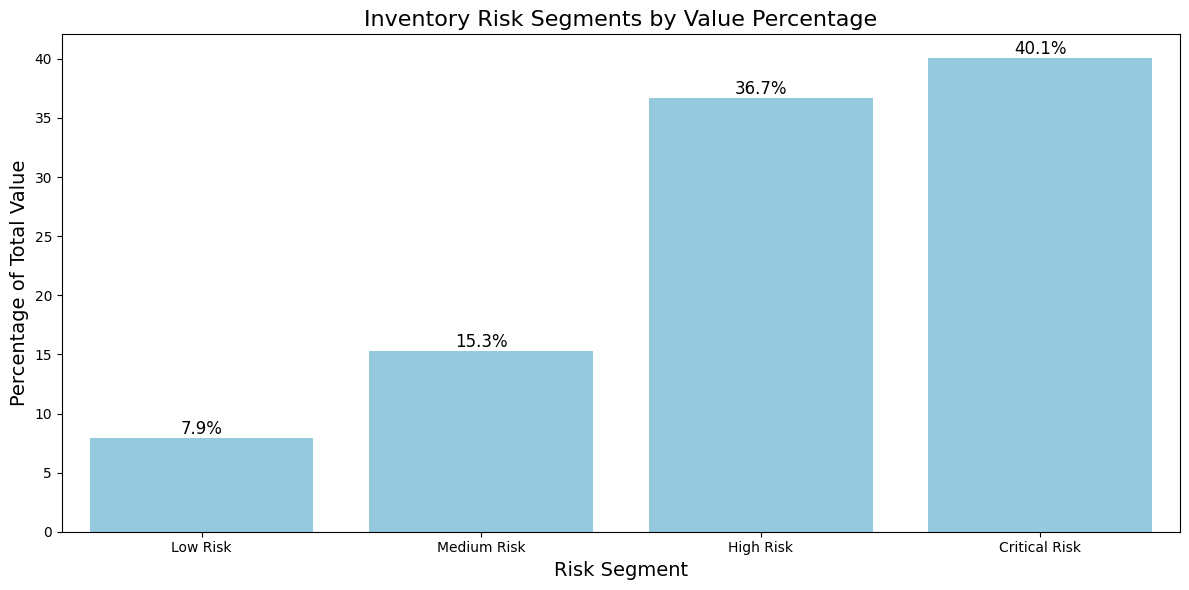


Top 10 Highest Risk Items (Critical Risk):
                               Grade  Recency    Monetary  RFM_Score
688            M.2407C 651566 BK150W      187   361200.00        4.0
641     ULTRAMID® A218 V35 BLACK 21N      184   442520.00        4.0
762        ULTRAMID A218 V35 NATURAL      141   392968.65        4.0
767    ULTRAMID® A218 V30 BLACK 21NS      158   466375.00        4.0
639  ULTRAMID® A218 V30 BLACK 34NG-K      124   349575.00        4.0
635        ULTRAMID A 402 H1 NATURAL      253  1031355.00        4.0
621      OMNIX 4050 BK 000 S25 P1000      226   865117.00        4.0
660   B. T85XF 900307 BBS910 BK 150W      176   519750.00        4.0
610                 NGC 3001 NATURAL      124   327525.00        4.0
389        B. FR 3010 500018 BK 150W       73   396930.00        3.8


In [3]:
# RFM Analysis for Inventory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



# Define current date (for recency calculation)
current_date = datetime.now()

# Calculate RFM metrics
inventory_rfm = pd.DataFrame({
    'Grade': deadstock_df['Grade'],
    'Stock ID': deadstock_df['Stock ID'],
    'Recency': deadstock_df['Days Since Last Dispatch'],  # Higher days = lower recency
    'Frequency': 1,  # Placeholder, will be calculated
    'Monetary': deadstock_df['Value(in Rs.)']
})

# Calculate frequency (count of each grade)
grade_frequency = deadstock_df.groupby('Grade')['Stock ID'].count()
inventory_rfm['Frequency'] = inventory_rfm['Grade'].map(grade_frequency)

# Create RFM scores
inventory_rfm['R_Score'] = pd.qcut(inventory_rfm['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')
inventory_rfm['F_Score'] = pd.qcut(inventory_rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4], duplicates='drop')
inventory_rfm['M_Score'] = pd.qcut(inventory_rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4], duplicates='drop')

# Convert to numeric
for col in ['R_Score', 'F_Score', 'M_Score']:
    inventory_rfm[col] = pd.to_numeric(inventory_rfm[col])

# Calculate final RFM score (for inventory, emphasize recency and monetary)
inventory_rfm['RFM_Score'] = (0.4 * inventory_rfm['R_Score'] + 
                             0.2 * inventory_rfm['F_Score'] + 
                             0.4 * inventory_rfm['M_Score'])

# Create segments
inventory_rfm['Segment'] = pd.qcut(inventory_rfm['RFM_Score'], 4, 
                                  labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk'])

# Analyze segments
segment_summary = inventory_rfm.groupby('Segment').agg({
    'Stock ID': 'count',
    'Monetary': 'sum',
    'Recency': 'mean'
}).rename(columns={
    'Stock ID': 'Count',
    'Monetary': 'Total Value (Rs.)',
    'Recency': 'Avg Days Since Movement'
})

segment_summary['Percentage of Items'] = segment_summary['Count'] / segment_summary['Count'].sum() * 100
segment_summary['Percentage of Value'] = segment_summary['Total Value (Rs.)'] / segment_summary['Total Value (Rs.)'].sum() * 100

print("\nRFM Segmentation Results:")
print(segment_summary)

# Visualize the segments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=segment_summary.index, y='Percentage of Value', data=segment_summary, color='skyblue')
plt.title('Inventory Risk Segments by Value Percentage', fontsize=16)
plt.xlabel('Risk Segment', fontsize=14)
plt.ylabel('Percentage of Total Value', fontsize=14)

# Add percentage labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Show top 10 highest risk items
high_risk_items = inventory_rfm[inventory_rfm['Segment'] == 'Critical Risk'].sort_values('RFM_Score', ascending=False).head(10)
print("\nTop 10 Highest Risk Items (Critical Risk):")
print(high_risk_items[['Grade', 'Recency', 'Monetary', 'RFM_Score']])



Decision Tree Model Performance:
Training accuracy: 0.7751
Testing accuracy: 0.5778

Feature Importance for Mismatch Prediction:
                 Feature  Importance
1  Opening Stock(in kgs)    0.465899
2           Rate(in Rs.)    0.334290
0  Closing Stock(in kgs)    0.199811


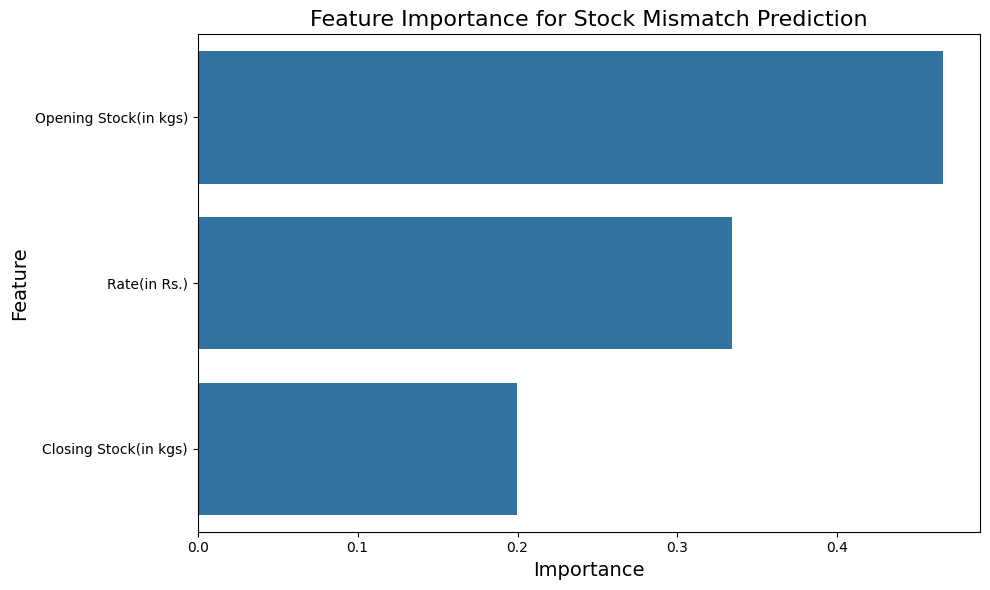

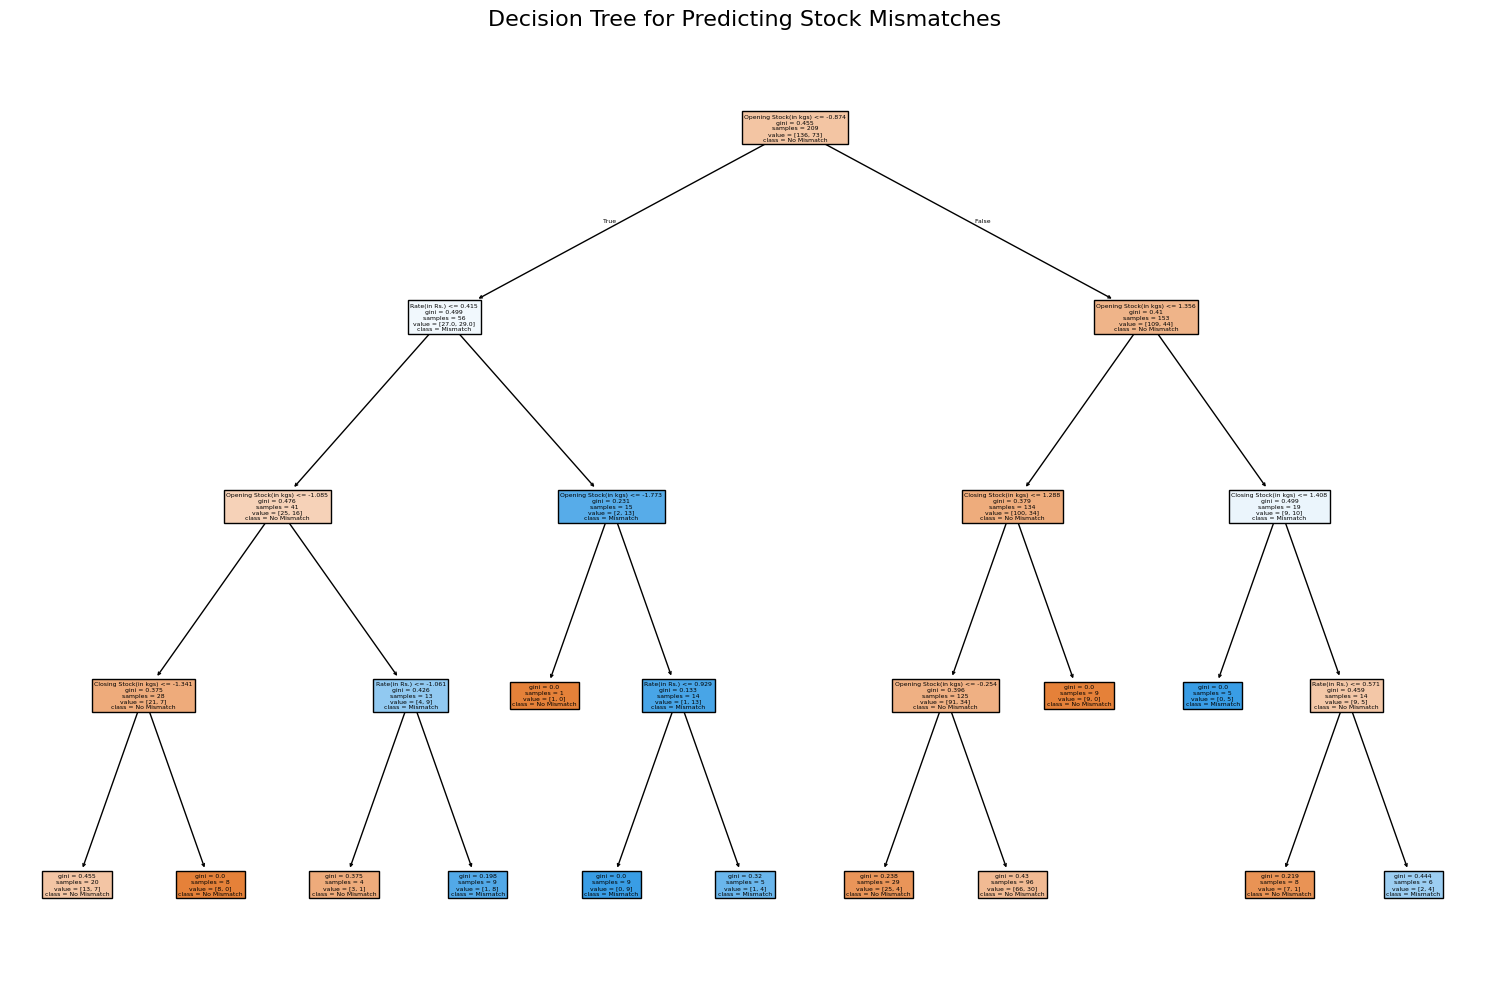

In [4]:
# Decision Tree Analysis for Stock Mismatch Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data
mismatch_df = pd.read_excel("stock_mismatch_cleaned.xlsx")
mismatch_df['Has Mismatch'] = mismatch_df['Mismatch'].apply(lambda x: 1 if x == 'Yes' else 0)

# Prepare features and target
features = ['Closing Stock(in kgs)', 'Opening Stock(in kgs)', 'Rate(in Rs.)']
X = mismatch_df[features]
y = mismatch_df['Has Mismatch']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train decision tree
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate model
train_score = dt_model.score(X_train, y_train)
test_score = dt_model.score(X_test, y_test)

print(f"\nDecision Tree Model Performance:")
print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")

# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance for Mismatch Prediction:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Stock Mismatch Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, filled=True, feature_names=features, class_names=['No Mismatch', 'Mismatch'])
plt.title('Decision Tree for Predicting Stock Mismatches', fontsize=16)
plt.tight_layout()
plt.show()


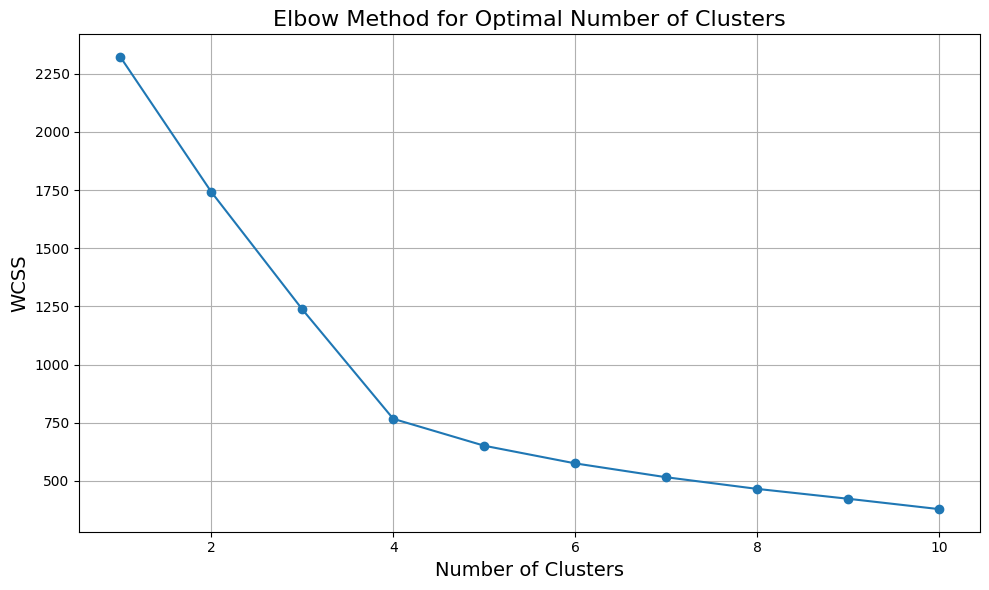

Cluster Analysis:
         Count  Value(in Rs.)      Quantity  Rate(in Rs.)  \
Cluster                                                     
0          382    84684941.73   1003.654450    215.248272   
1            6     6909540.00    551.000000   2090.000000   
2            6    24551965.11  14025.000000    299.645000   
3          380    81948344.35    881.434211    239.708605   

         Days Since Last Dispatch  Percentage of Items  Percentage of Value  
Cluster                                                                      
0                      284.057592            49.354005            42.749706  
1                      535.500000             0.775194             3.487997  
2                      452.833333             0.775194            12.394049  
3                      733.510526            49.095607            41.368248  


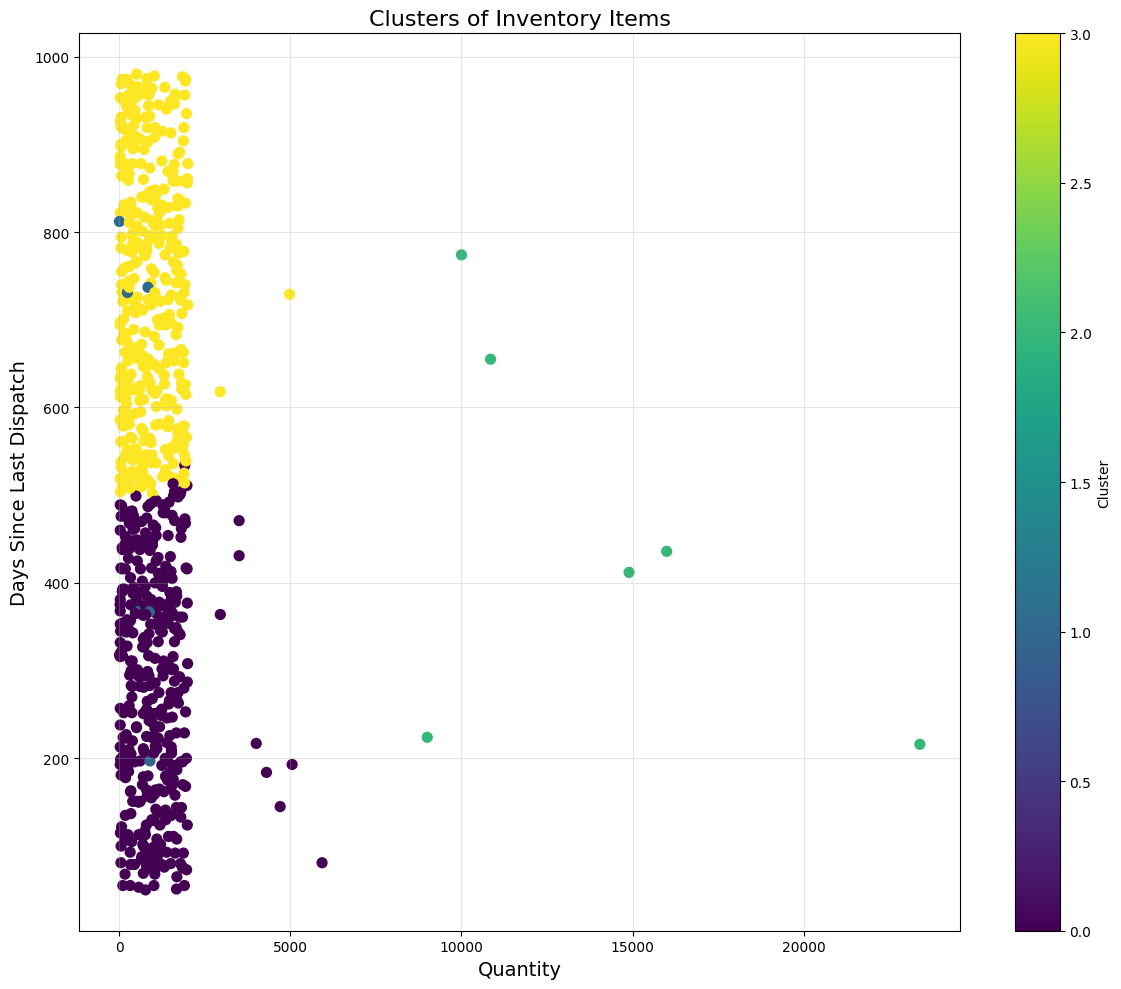

<Figure size 1400x800 with 0 Axes>

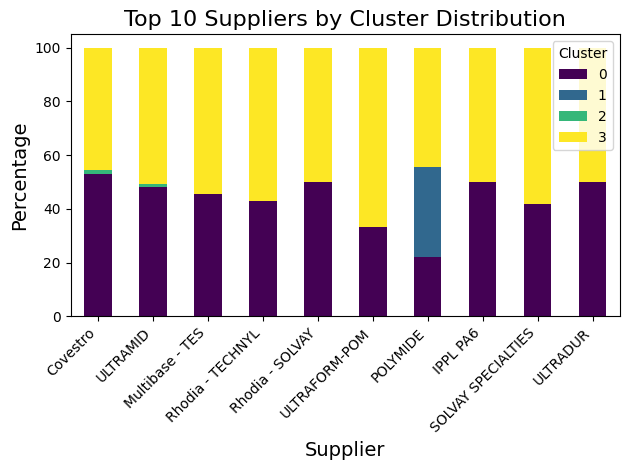

In [5]:
# K-Means Clustering for Supplier-Material Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Prepare data for clustering
clustering_data = deadstock_df[['Quantity', 'Rate(in Rs.)', 'Days Since Last Dispatch']]

# Handle missing values
clustering_data = clustering_data.fillna(clustering_data.mean())

# Scale the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Determine optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(clustering_data_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('WCSS', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Based on elbow method, determine optimal clusters (e.g. 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
deadstock_df['Cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Analyze clusters
cluster_analysis = deadstock_df.groupby('Cluster').agg({
    'Stock ID': 'count',
    'Value(in Rs.)': 'sum',
    'Quantity': 'mean',
    'Rate(in Rs.)': 'mean',
    'Days Since Last Dispatch': 'mean'
}).rename(columns={'Stock ID': 'Count'})

cluster_analysis['Percentage of Items'] = cluster_analysis['Count'] / cluster_analysis['Count'].sum() * 100
cluster_analysis['Percentage of Value'] = cluster_analysis['Value(in Rs.)'] / cluster_analysis['Value(in Rs.)'].sum() * 100

print("Cluster Analysis:")
print(cluster_analysis)

# Visualize the clusters
plt.figure(figsize=(12, 10))
plt.scatter(deadstock_df['Quantity'], deadstock_df['Days Since Last Dispatch'], 
           c=deadstock_df['Cluster'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.xlabel('Quantity', fontsize=14)
plt.ylabel('Days Since Last Dispatch', fontsize=14)
plt.title('Clusters of Inventory Items', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze supplier distribution across clusters
supplier_cluster = pd.crosstab(deadstock_df['Supplier'], deadstock_df['Cluster'])
supplier_cluster_pct = supplier_cluster.div(supplier_cluster.sum(axis=1), axis=0) * 100

# Plot supplier distribution across clusters
plt.figure(figsize=(14, 8))
top_suppliers = deadstock_df['Supplier'].value_counts().head(10).index
supplier_cluster_pct.loc[top_suppliers].plot(kind='bar', stacked=True, 
                                            colormap='viridis')
plt.title('Top 10 Suppliers by Cluster Distribution', fontsize=16)
plt.xlabel('Supplier', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



APRIORI ASSOCIATION RULE MINING FOR INVENTORY PATTERNS
Minimum support threshold: 0.005
Found 142 frequent itemsets.
Found 122 association rules.

Top 10 Association Rules:
                                    antecedents  \
0    (B. T85XF 900307 BBS910 BK 150W_Mismatch1)   
1                              (Reason_Damaged)   
45            (M.2407C 651566 BK150W_Mismatch1)   
44                             (Reason_Damaged)   
28            (M.2407C 020003 BK150W_Mismatch1)   
29                          (Reason_Illiteracy)   
107           (ULTRAMID A218 NATURAL_Mismatch1)   
106                         (Reason_Illiteracy)   
71    (MAKROLON 9415C 101645 BK 150W_Mismatch1)   
70                                (Reason_Lost)   

                                    consequents   support  confidence  \
0                              (Reason_Damaged)  0.006689    1.000000   
1    (B. T85XF 900307 BBS910 BK 150W_Mismatch1)  0.006689    0.095238   
45                             (Reason_Damage

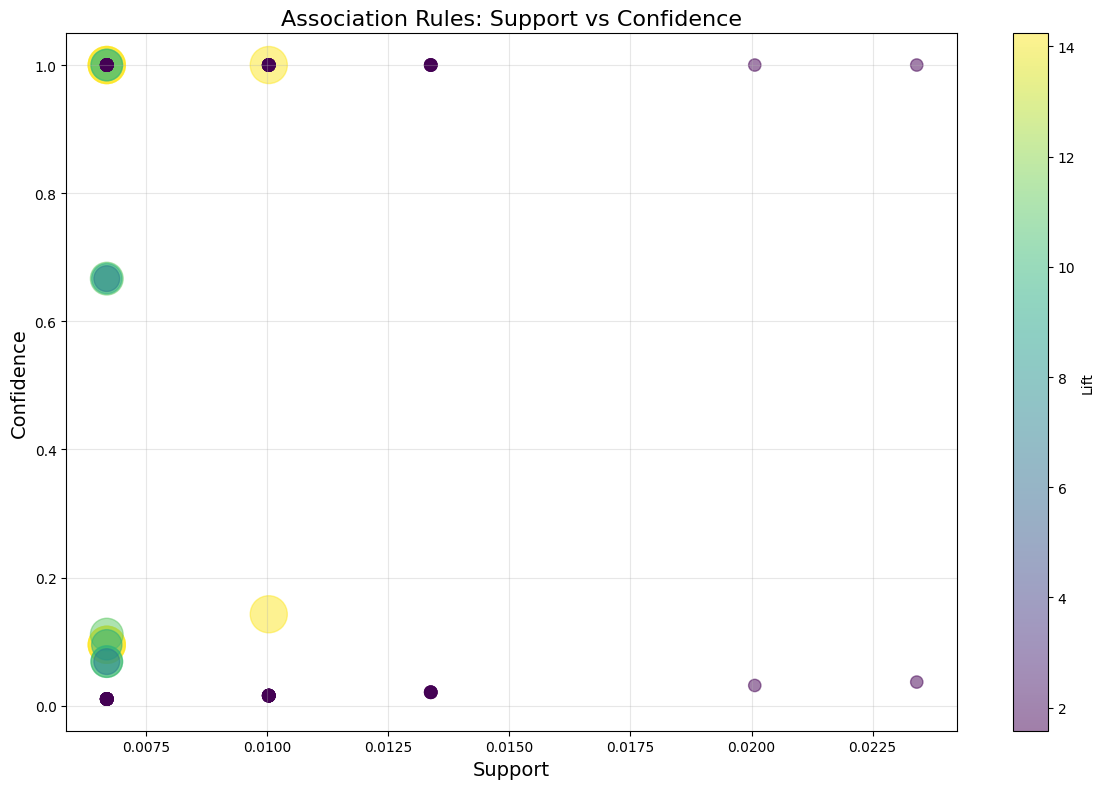

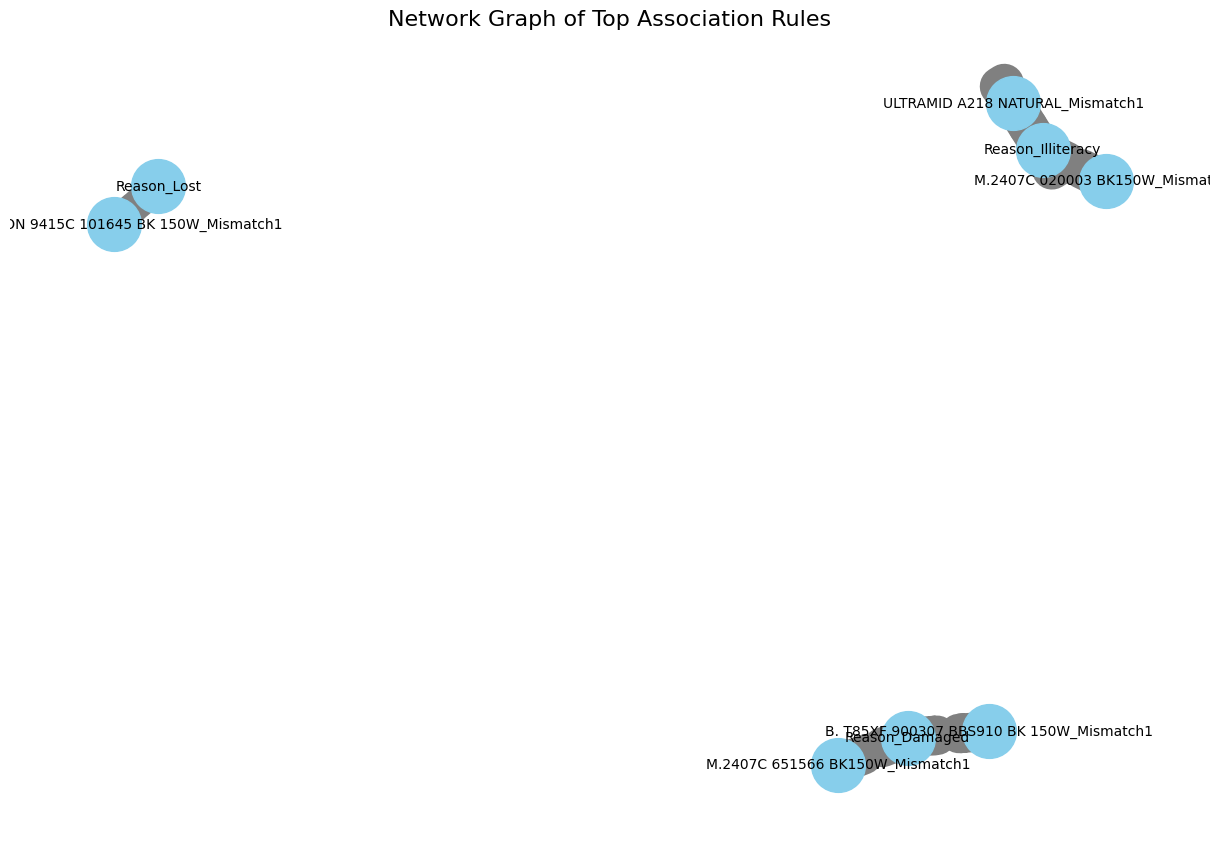

In [6]:
# Association Rule Mining for Stock Movement Patterns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

# Load data
'''mismatch_df = pd.read_excel("stock-mismatch.xlsx")
deadstock_df = pd.read_excel("deadstock.xlsx")'''

print("\nAPRIORI ASSOCIATION RULE MINING FOR INVENTORY PATTERNS")

# Prepare data: Create a transaction matrix with boolean values
# Combine grade and mismatch status
mismatch_df['Has_Mismatch'] = mismatch_df['Mismatch'].apply(lambda x: 1 if x == 'Yes' else 0)
mismatch_df['Grade_Mismatch'] = mismatch_df['Grade'] + '_Mismatch' + mismatch_df['Has_Mismatch'].astype(str)

# Create transaction matrix with one-hot encoding
transaction_matrix = pd.get_dummies(mismatch_df['Grade_Mismatch']).astype(bool)

# Add reason for mismatch to the transaction matrix
reason_dummies = pd.get_dummies(mismatch_df['Reason for Mismatch'], prefix='Reason').astype(bool)
transaction_matrix = pd.concat([transaction_matrix, reason_dummies], axis=1)

# Apply apriori algorithm with lower thresholds
min_support = 0.005  # Lower support threshold
print(f"Minimum support threshold: {min_support}")
frequent_itemsets = apriori(transaction_matrix, min_support=min_support, use_colnames=True)

# Check if frequent itemsets were found
if len(frequent_itemsets) == 0:
    print("No frequent itemsets found. Try further reducing the minimum support threshold.")
else:
    print(f"Found {len(frequent_itemsets)} frequent itemsets.")
    
    # Generate association rules with lower threshold
    min_threshold = 0.5  # Lower lift threshold
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold)
    
    # Check if association rules were found
    if len(rules) == 0:
        print("No association rules found. Try further reducing the minimum threshold.")
    else:
        # Sort rules by lift for better insights
        rules = rules.sort_values('lift', ascending=False)
        
        print(f"Found {len(rules)} association rules.")
        print("\nTop 10 Association Rules:")
        print(rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
        
        # Visualize the results - Support vs Confidence scatter plot with lift as point size
        plt.figure(figsize=(12, 8))
        plt.scatter(rules['support'], rules['confidence'], 
                    alpha=0.5, 
                    s=[50 * l for l in rules['lift']], 
                    c=rules['lift'], 
                    cmap='viridis')
        plt.colorbar(label='Lift')
        plt.xlabel('Support', fontsize=14)
        plt.ylabel('Confidence', fontsize=14)
        plt.title('Association Rules: Support vs Confidence', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('association_rules.png', dpi=300)
        plt.show()
        
        # Try to create network visualization if networkx is available
        try:
            import networkx as nx
            
            # Create directed graph for top rules
            G = nx.DiGraph()
            
            # Add edges for top 10 rules (or fewer if less available)
            top_n = min(10, len(rules))
            for i in range(top_n):
                rule = rules.iloc[i]
                antecedent = ', '.join(list(rule['antecedents']))
                consequent = ', '.join(list(rule['consequents']))
                G.add_edge(antecedent, consequent, weight=rule['lift'])
            
            # Draw network graph
            plt.figure(figsize=(12, 8))
            pos = nx.spring_layout(G)
            edges = G.edges()
            weights = [G[u][v]['weight'] * 2 for u, v in edges]
            
            nx.draw(G, pos, with_labels=True, node_color='skyblue', 
                    node_size=1500, edge_color='gray', width=weights, 
                    font_size=10, arrows=True)
            plt.title('Network Graph of Top Association Rules', fontsize=16)
            plt.tight_layout()
            plt.savefig('association_rules_network.png', dpi=300)
            plt.show()
            
        except ImportError:
            print("NetworkX package not available for network visualization.")


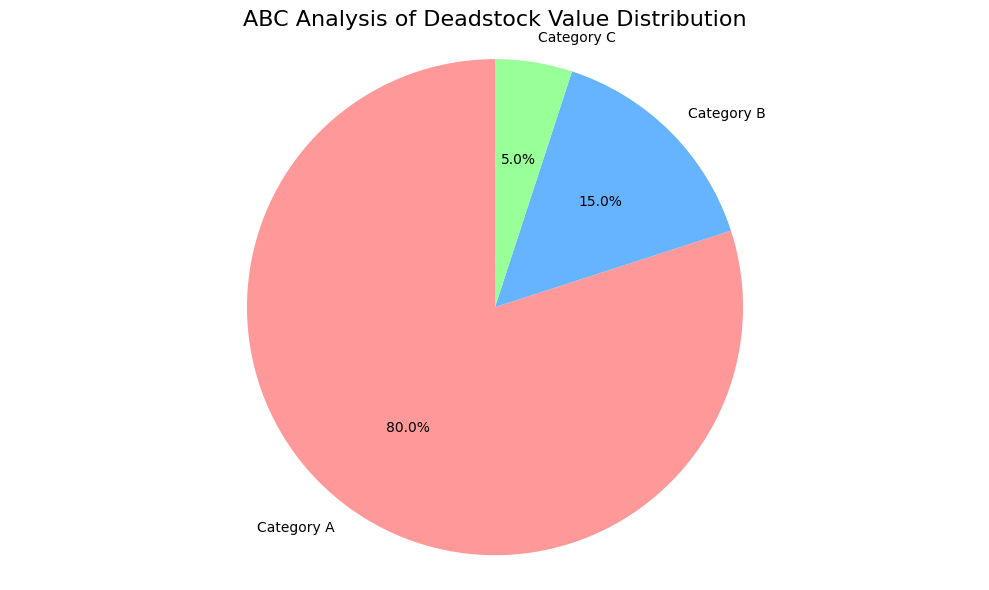


INSIGHT 3: ABC ANALYSIS
Category A: 304 items (39.28% of total) account for 79.99% of deadstock value
Category B: 175 items (22.61% of total) account for 14.98% of deadstock value
Category C: 203 items (26.23% of total) account for 5.03% of deadstock value


In [7]:
#ABC Analysis
deadstock_df['Turnover Ratio'] = deadstock_df['Quantity'] / deadstock_df['Days Since Last Dispatch']
deadstock_df.sort_values(by='Value(in Rs.)', ascending=False, inplace=True)
deadstock_df['Cumulative Value'] = deadstock_df['Value(in Rs.)'].cumsum()
deadstock_df['Cumulative Value %'] = deadstock_df['Cumulative Value'] / deadstock_df['Value(in Rs.)'].sum() * 100

# Assign ABC categories
deadstock_df['Category'] = pd.cut(
    deadstock_df['Cumulative Value %'],
    bins=[0, 80, 95, 100],
    labels=['A', 'B', 'C']
)

category_counts = deadstock_df['Category'].value_counts()
category_values = deadstock_df.groupby('Category')['Value(in Rs.)'].sum()
category_percentages = category_values / category_values.sum() * 100

plt.figure(figsize=(10, 6))
plt.pie(category_percentages, labels=['Category ' + idx for idx in category_percentages.index], 
        autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('ABC Analysis of Deadstock Value Distribution', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig('abc_analysis.png', dpi=300)
plt.show()

# INSIGHT 3: ABC Analysis
print("\nINSIGHT 3: ABC ANALYSIS")
print(f"Category A: {category_counts['A']} items ({category_counts['A']/len(deadstock_df)*100:.2f}% of total) account for {category_percentages['A']:.2f}% of deadstock value")
print(f"Category B: {category_counts['B']} items ({category_counts['B']/len(deadstock_df)*100:.2f}% of total) account for {category_percentages['B']:.2f}% of deadstock value")
print(f"Category C: {category_counts['C']} items ({category_counts['C']/len(deadstock_df)*100:.2f}% of total) account for {category_percentages['C']:.2f}% of deadstock value")